# Optimal Control Project
### Tyler Mansfield and Eric Todd
### Math 438 -- April, 7, 2020

In [32]:
from scipy.integrate import solve_bvp, simps
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg as la
import pandas as pd
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import animation
from copy import deepcopy
from scipy.interpolate import interp1d as interpolate

#### Mathematical Tools

In [33]:
#Global parameters lamda, K, M, and params_list must be set before using the functions below

In [34]:
def obstacle_cost(x, y, t, params):
    """Params is of the form
    Each tuple should be of the form ('r', x_0, y_0, l_x, l_y,v_x,v_y) or ('e', x_0, y_0,r_x, r_y, v_x,v_y) where
            'r' indicates a rectangular obstacle, and 'e' indicates an elliptical obstacle,
            (x_0, y_0) is the initial corner for rectangular obstacles and initial center for ellipsoids
            (l_x, l_y) is the width and height of the rectangular obstacle
            (r_x, r_y) is the radii in the x and y directions respectively for an elliptical obstacle
            (v_x, v_y) is the constant velocity for the obstacle in the x and y directions"""
    
    if params[0] == 'e':
        return K / ((1/params[3]**2 * (x - params[5]*t - params[1])**2 + 1/params[4]**2 * (y - params[6]*t - params[2])**2)**lamda + 1)
        
    if params[0] == 'r':
        return K / ((2/params[3] * (x - params[5]*t - params[1]))**lamda + (2/params[4] * (y - params[6]*t - params[2]))**lamda + 1)
    
    raise ValueError('Params is not defined correctly')
    
def obstacle_deriv_s1(x, y, t, params):
    if params[0] == 'e':
        obj = 1/params[3]**2 * (x - params[5]*t - params[1])**2 + 1/params[4]**2 * (y - params[6]*t - params[2])**2
        num = 2*K*lamda*(x - params[5]*t - params[1])*obj**(lamda-1)
        den = params[3]**2 * (obj ** lamda + 1)**2
        return -1 * num/den
    
    if params[0] == 'r':
        obj1 = 1/params[3] * (x - params[5]*t - params[1]) 
        obj2 = 1/params[4] * (y - params[6]*t - params[2])
        num = K*(2**lamda)*lamda*(obj1)**(lamda-1)
        den = params[3] * ((2*obj1)**lamda + (2 * obj2)**lamda + 1)**2
        return -1 * num/den

def obstacle_deriv_s2(x, y, t, params):
    if params[0] == 'e':
        obj = 1/params[3]**2 * (x - params[5]*t - params[1])**2 + 1/params[4]**2 * (y - params[6]*t - params[2])**2
        num = 2*K*lamda*(y - params[6]*t - params[2])*obj**(lamda-1)
        den = params[4]**2 * (obj ** lamda + 1)**2
        return -1 * num/den
    
    if params[0] == 'r':
        obj1 = 1/params[3] * (x - params[5]*t - params[1]) 
        obj2 = 1/params[4] * (y - params[6]*t - params[2])
        num = K*(2**lamda)*lamda*(obj2)**(lamda-1)
        den = params[4] * ((2*obj1)**lamda + (2 * obj2)**lamda + 1)**2
        return -1 * num/den

def f(t, y):
    """
    Our system of differential equations y' = f(t,y)
    [y[0], y[1], y[2], y[3]] is our state
    [y[4], y[5], y[6], y[7]] is our costate
    """
    
    output = np.zeros_like(y)
    
    #Our state
    output[0] = y[2]
    output[1] = y[3]
    output[2] = 0.5 * y[6] / M
    output[3] = 0.5 * y[7] / M
    
    #Our costate
    for param in params_list:
        output[4] += obstacle_deriv_s1(y[0], y[1], t, param)
        output[5] += obstacle_deriv_s2(y[0], y[1], t, param)
        
    
    output[6] = -1 * y[4]
    output[7] = -1 * y[5]
    return output

def f_naive(t, y):
    """
    Our system of differential equations y' = f(t,y)
    [y[0], y[1], y[2], y[3]] is our state
    [y[4], y[5], y[6], y[7]] is our costate
    """
    
    output = np.zeros_like(y)
    
    #Our state
    output[0] = y[2]
    output[1] = y[3]
    output[2] = 0.5 * y[6] / M
    output[3] = 0.5 * y[7] / M
    
    #Our costate
    output[4] = 0
    output[5] = 0
    output[6] = -1 * y[4]
    output[7] = -1 * y[5]
    return output

def J(t, y, u1, u2, params_list, components = False):
    """Our cost functional"""
    #Object intersection penalty
    object_penalty = 0
    
    for param in params_list:
        object_penalty += obstacle_cost(y[0], y[1], t, param)
                   
    #Large acceleration penalty
    accel = M * (u1**2 + u2 **2)
    
    if components == True:
        return object_penalty, accel
    
    return 1 + object_penalty + accel
    

def find_path(params_list, bc, x_guess, y_guess, J = J, f = f, T_guess = 10, t_steps = 200, show_plots = True):
    """Finds the optimal path for our Optimal Control Problem
    
    Returns:
    t_vals: The time steps
    x_vals: The x values of our path at each time step
    y_vals: The y values of our path at each time step
    T: The optimal final time"""
        
    best_path_found = False
    
    while best_path_found == False:
        #Expand around T
        T_vals = np.linspace(T_guess * 0.5, T_guess * 1.5, 40)
        
        best_functional_val = np.inf
        best_T = np.inf
        
        #Find best value for T
        for T in T_vals:
            #Initialize
            t_vals = np.linspace(0,T,t_steps)
            y_0 = np.zeros((8,t_vals.size))
            
            #Make initial guess
            lin = np.linspace(0,1,t_vals.size)
            y_0[0] = x_guess(lin)
            y_0[1] = y_guess(lin)
            y_0[2] = np.gradient(y_0[0], t_vals)
            y_0[3] = np.gradient(y_0[1], t_vals)
            y_0[6] = 2 * M * np.gradient(y_0[2], t_vals)
            y_0[7] = 2 * M * np.gradient(y_0[3], t_vals)
            
            #Solve
            solution = solve_bvp(f, bc, t_vals, y_0)
            if solution.success == False:
                continue
            t_vals = solution.x
            t_step = t_vals[1] - t_vals[0]
            y = solution.y
            
            #Evaluate functional at time steps
            u1 = y[6]/(2*M)
            u2 = y[7]/(2*M)
            J_vals = np.zeros_like(t_vals)
            
            for i in range(len(t_vals)):    
                J_vals[i] = J(t_vals[i], y[:,i], u1[i], u2[i], params_list)
                
            #Evaluate functional
            functional_val = simps(J_vals, t_vals)
            if functional_val < best_functional_val:
                best_functional_val = functional_val
                best_T = T
                
        if best_T == np.inf:
            raise ValueError("Bad T values")
        
        #See if the optimal T was on the boundary of our guesses
        if best_T <= T_guess * 0.6:
            T_guess = T_vals[0] * 0.85
            print("New T_guess: " + str(T_guess))
            
        elif best_T >= T_guess * 1.4:
            T_guess = T_vals[-1] / 0.85
            print("New T_guess: " + str(T_guess))
        
        else:
            best_path_found = True
    
    ##Solve finally given the best T
    #Initialize
    t_vals = np.linspace(0,best_T,t_steps)
    y_0 = np.zeros((8,t_vals.size))
    
    #Make initial guess
    lin = np.linspace(0,1,t_vals.size)
    y_0[0] = x_guess(lin)
    y_0[1] = y_guess(lin)
    y_0[2] = np.gradient(y_0[0], t_vals)
    y_0[3] = np.gradient(y_0[1], t_vals)
    y_0[6] = 2 * M * np.gradient(y_0[2], t_vals)
    y_0[7] = 2 * M * np.gradient(y_0[3], t_vals)
            
    #Solve
    solution = solve_bvp(f, bc, t_vals, y_0)
    t_vals = solution.x
    t_step = t_vals[1] - t_vals[0]
    y = solution.y
            
    #Evaluate functional at time steps
    u1 = y[6]/(2*M)
    u2 = y[7]/(2*M)
    J_vals = np.zeros_like(t_vals)
    obst_contrib = np.zeros_like(t_vals)
    accel_contrib = np.zeros_like(t_vals)
            
    for i in range(len(t_vals)):    
        obst_contrib[i], accel_contrib[i] = J(t_vals[i], y[:,i], u1[i], u2[i], params_list, components = True)
        J_vals[i] = 1 + obst_contrib[i] + accel_contrib[i]
        
    if show_plots == True:
        print("Total Cost: " + str(simps(J_vals, t_vals)))
        
        ##Compare to Naive solution
        y_0_naive = np.zeros((8,t_vals.size))
        solution_naive = solve_bvp(f_naive, bc, t_vals, y_0_naive)
        t_vals_naive = solution_naive.x
        y_naive = solution_naive.y
        
        #Evaluate functional at time steps
        u1_naive = y_naive[6]/(2*M)
        u2_naive = y_naive[7]/(2*M)
        J_vals_naive = np.zeros_like(t_vals_naive)
            
        for i in range(len(t_vals_naive)):    
            J_vals_naive[i] = J(t_vals_naive[i], y_naive[:,i], u1_naive[i], u2_naive[i], params_list)
                
        #Evaluate functional
        print("Naive Cost: " + str(simps(J_vals_naive, t_vals_naive)))
        
        plt.figure(figsize= (15,5))
        plt.subplot(1,2,1)
        plt.plot(t_vals, J_vals, label = "Total Cost")
        plt.plot(t_vals, obst_contrib, ":", label = "Cost from Obstacle(s)")
        plt.plot(t_vals, accel_contrib, ":", label = "Cost from Acceleration")
        plt.legend()
        plt.title("Functional Cost over Time")
        plt.xlabel("t")
        plt.ylabel(r"$L(t,\vec{s},\vec{u})$")
        
        for p in range(1,int(t_vals[-1]//1)):
            argument = np.argmax(t_vals > p)
            if p == 1:
                plt.scatter(t_vals[argument], J_vals[argument], c='k', label="Time Increments")
            else:
                plt.scatter(t_vals[argument], J_vals[argument], c='k')
        
        plt.legend()
        plt.subplot(1,2,2)
        
        plt.plot(y[0], y[1])
        plt.title("Path of object")
        plt.scatter(y[0][0], y[1][0], label = "Start")
        plt.xlabel("x")
        plt.ylabel("y")
        for p in range(1,int(t_vals[-1]//1)):
            argument = np.argmax(t_vals > p)
            if p == 1:
                plt.scatter(y[0][argument], y[1][argument], c='k', label="Time Increments")
            else:
                plt.scatter(y[0][argument], y[1][argument], c='k')
        plt.legend()
        plt.axis('equal')
#         plt.savefig('example3_3_cost.pdf',bbox_inches="tight", dpi=300)
        plt.show()
    
    #Interpolate for even spread of time steps
    fx = interpolate(t_vals, y[0], kind = 'cubic')
    fy = interpolate(t_vals, y[1], kind = 'cubic')
    t_vals_new = np.linspace(0, t_vals[-1], t_steps)
    
    #Return the best states
    opt_traj = np.vstack((t_vals_new, fx(t_vals_new), fy(t_vals_new)))
    
    return opt_traj

#### Animation Tools

In [35]:
def animate_opt_traj(opt_traj, *params_list, bounds=None, save_filename='optimal_trajectory_animation.mp4'):
    """
    Animates the optimal trajectory and the moving obstacles to demonstrate an optimal control
    
    Parameters
    ----------
    opt_traj : ndarray of shape (T,3)
            The array of the computed optimal trajectory x* where each observation is (time,x,y)
    params_list : iterable of tuples
            A list of tuples containing the parameters for the different obstacles (__,x0,y0,__,__,v_x,v_y)
            Each tuple should be of the form ('r', x_0, y_0, l_x, l_y,v_x,v_y) or ('e', x_0, y_0,r_x, r_y, v_x,v_y) where
            'r' indicates a rectangular obstacle, and 'e' indicates an elliptical obstacle,
            (x_0, y_0) is the initial center for rectangular obstacles and initial center for ellipsoids
            (l_x, l_y) is the width and height of the rectangular obstacle
            (c_x, c_y) is the radii in the x and y directions respectively for an elliptical obstacle
            (v_x, v_y) is the constant velocity for the obstacle in the x and y directions
    save_filename : str
            The filename to save the animation as. If None, no animation is saved.
    """
    
    # Initialize our figure
    fig = plt.figure()
    
    obstacle_params = deepcopy(params_list)
    
    # Define helper function to grab desired subsets of the obstacle parameters
    def param_subset(i):
        """
        Takes a lambda function indicating the index to grab from x
        i.e. f = lambda x: x[i]
        """
        return list(map(lambda x: x[i], obstacle_params))
       
    # Grab the types of the obstacles
    if len(obstacle_params) == 1:
        obstacle_params = obstacle_params[0]
    if save_filename is not None and save_filename[-4:] != '.mp4':
        raise ValueError("Invalid filename for saving: {}".format(save_filename))
    # Make sure opt_traj is the right shape
    if opt_traj.shape[0] ==3:
        opt_traj = opt_traj.T
        
    obstacle_type = param_subset(0)
    obstacles = []
    
    # Initialize our obstacles
    for i, obstacle in enumerate(obstacle_params):
        obs_type, x0, y0, dim1, dim2,v_x,v_y = obstacle # unpack the obstacle variables
        if obs_type == 'e':
            patch = Ellipse((x0,y0), 2*dim1, 2*dim2, color='green')
        elif obs_type == 'r':
            # update rectangle parameters internally to be the center, instead of bottom left corner
            obstacle_params[i] = (obs_type, x0-0.5*dim1, y0-0.5*dim2, dim1, dim2,v_x,v_y) 
            patch = Rectangle((x0-0.5*dim1, y0-0.5*dim2), dim1, dim2, color='green')
        else:
            raise ValueError("Invalid Obstacle type specified: {} in tuple {}".format(obs_type, i+1))
        
        axis = plt.gca() # get the current axis and add the patch
        axis.add_patch(patch)
        obstacles.append(patch)
    
    # Get our initial points, final points for each obstacle
    T = opt_traj.shape[0]
    t_s = opt_traj[:,0]
    x0_s = param_subset(1)
    y0_s = param_subset(2)
    v_x_s = param_subset(5)
    v_y_s = param_subset(6)           
    
    # Compute dx,dy for each obstacle: (T,j), so that it moves at the same speed as the particle (t_s)
    obstacle_path_X = np.array(x0_s) + t_s.reshape(-1,1) * np.array(v_x_s)
    obstacle_path_Y = np.array(y0_s) + t_s.reshape(-1,1) * np.array(v_y_s)
        
    # Compute bounds for displaying all the obstacles.
    
    if bounds is None:
      # Compute bounds for displaying the optimal trajectory\n",
        x_max = max(abs(np.min(opt_traj[:,1])), abs(np.max(opt_traj[:,1])))*2
        x_min = -x_max
        y_max = max(abs(np.min(opt_traj[:,2])), abs(np.max(opt_traj[:,2])))*2
        y_min = -y_max
    elif len(bounds) == 4:
        x_min, x_max, y_min, y_max = bounds
    else:       
        x_min, x_max = np.min(obstacle_path_X), np.max(obstacle_path_X)
        y_min, y_max = np.min(obstacle_path_Y), np.max(obstacle_path_Y)
    
    # Get the current figure & axis 
    fig, axis = plt.gcf(), plt.gca()

    #Plot the earth as a particle and its orbit
    optimal_particle = axis.plot([],[], marker='o',color='b')[0]
    optimal_path = axis.plot([],[], '--', color='royalblue')[0]
    obstacles.append((optimal_path, optimal_particle))
    obstacle_type.append('x*')

    def update(i, *obstacles):
        for j, obstacle in enumerate(obstacles):
            if obstacle_type[j] == 'r': # Display Rectangular Obstacles
                x,y = obstacle.get_xy()
                obstacle.set_xy((obstacle_path_X[i,j],obstacle_path_Y[i,j]))
                if obstacle.get_bbox().contains(opt_traj[i,1],opt_traj[i,2]):
                    obstacle.set_color('red')
                else:
                    obstacle.set_color('green')
            elif obstacle_type[j] == 'e': # Display Elliptical Obstacles
                x,y = obstacle.get_center()
                obstacle.set_center((obstacle_path_X[i,j],obstacle_path_Y[i,j]))
                if obstacle.contains_point(axis.transData.transform((opt_traj[i,1],opt_traj[i,2]))):
                    obstacle.set_color('red')
                else:
                    obstacle.set_color('green')
            else:  # Display our optimal trajectory
                obstacle[0].set_data(opt_traj[:i+1,1],opt_traj[:i+1,2])
                obstacle[1].set_data(opt_traj[i,1],opt_traj[i,2])
        return obstacles
    
    # Set the min and max values for x and y to plot
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)

    anim = animation.FuncAnimation(fig, update, fargs = obstacles, frames=T, interval=25)
    if save_filename is not None:
        anim.save(save_filename, dpi=150)
    plt.close()

### Example 1: Object Coming At You

Total Cost: 17.01208522837923
Naive Cost: 68.14639662218389


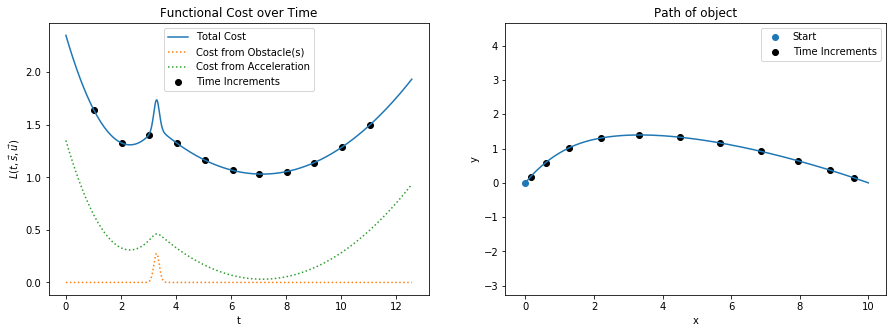

In [36]:
#Global Parameters
#K scales the penalty for intersecting objects
#M scales the pentaly for large accleration
#lamda is a constant that makes softer/harder boundaries for our obstacles
lamda = 20
K = 50
M = 5
params_list = [('e', 5, 0, 1, 1, -1, 0)]

def bc(ya, yb):
    "Our boundary conditions"
    return np.array([ya[0], ya[1], ya[2], ya[3], yb[0] - 10, yb[1], yb[2], yb[3]])

def x_guess(t):
    """
    A guess of the the location of x once the object has completed (t * 100)%
    of the total path
    Note that we should have x_guess(0) = 0 and x_guess(1) = final_x_location
    """
    return 10 * t**2

def y_guess(t):
    """
    A guess of the the location of y once the object has completed (t * 100)%
    of the total path
    Note that we should have y_guess(0) = y_guess(1) = 0
    """
    return 64 * t **2 * (t-1)**4

solution = find_path(params_list, bc, x_guess, y_guess, T_guess = 20)
animate_opt_traj(solution, params_list, bounds=[0,10,-3,3],save_filename= "example1_new.mp4")

<video controls src="example1_new.mp4"/>

### Example 2: Twists and Turns

Total Cost: 22.67351029342824
Naive Cost: 389.1682014336181


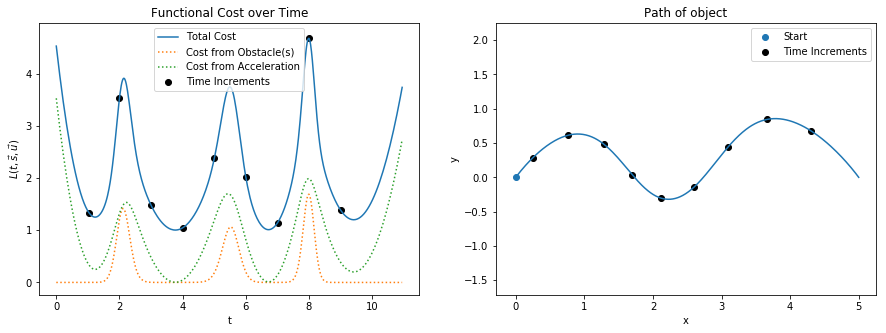

In [16]:
#Global Parameters
#K scales the penalty for intersecting objects
#M scales the pentaly for large accleration
#lamda is a constant that makes softer/harder boundaries for our obstacles
lamda = 25
K = 160
M = 4
params_list = [('e', np.pi/4, -1 - 3, np.sqrt(4/9), 2 + np.sqrt(3), 0, 0.25), ('e', 3*np.pi/4, 1 + 2, np.sqrt(4/9), np.sqrt(3) + 2, 0, 0.15), ('e', 5*np.pi/4, -1 - 2, np.sqrt(4/9), np.sqrt(3) + 2, -0.03, -0.03)]

def bc(ya, yb):
    "Our boundary conditions"
    return np.array([ya[0], ya[1], ya[2], ya[3], yb[0] - 5, yb[1], yb[2], yb[3]])

def x_guess(t):
    """
    A guess of the the location of x once the object has completed (t * 100)%
    of the total path
    Note that we should have x_guess(0) = 0 and x_guess(1) = final_x_location
    """
    return 5 * t

def y_guess(t):
    """
    A guess of the the location of y once the object has completed (t * 100)%
    of the total path
    Note that we should have y_guess(0) = y_guess(1) = 0
    """
    return np.sin(3*np.pi*t)

solution = find_path(params_list, bc, x_guess, y_guess, T_guess = 15)
animate_opt_traj(solution, params_list, bounds=[0,5,-3,3], save_filename= "example2_new.mp4")

<video src="example2_new.mp4" controls>

### Example 3: Competing Obstacles

Total Cost: 68.31140525343652
Naive Cost: 1241.4595440335195


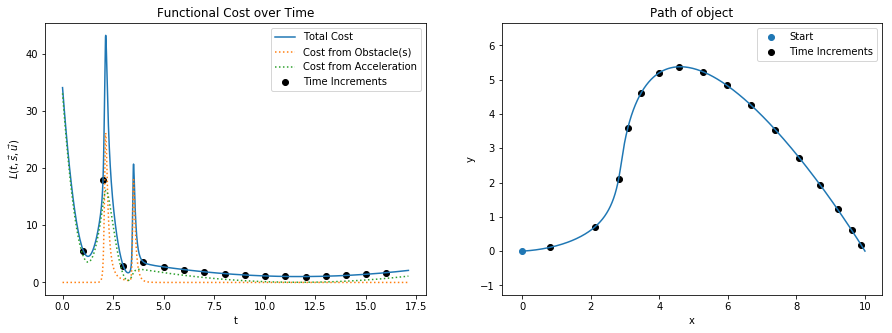

In [37]:
#Global Parameters
#K scales the penalty for intersecting objects
#M scales the pentaly for large accleration
#lamda is a constant that makes softer/harder boundaries for our obstacles
lamda = 20
K = 500
M = 8
params_list = [('r', 0, 3, 4, 2, 0, -0.5), ('r', 0, -3, 4, 2, 0, 0.5), ('r', 7,0,1,5,-1,0)]

def bc(ya, yb):
    "Our boundary conditions"
    return np.array([ya[0], ya[1], ya[2], ya[3], yb[0] - 10, yb[1], yb[2], yb[3]])

def x_guess(t):
    """
    A guess of the the location of x once the object has completed (t * 100)%
    of the total path
    Note that we should have x_guess(0) = 0 and x_guess(1) = final_x_location
    """
    return 10 * t

def y_guess(t):
    """
    A guess of the the location of y once the object has completed (t * 100)%
    of the total path
    Note that we should have y_guess(0) = y_guess(1) = 0
    """
    return 32 * t **4 * (t-1)**2


solution = find_path(params_list, bc, x_guess, y_guess, T_guess = 15)
# animate_opt_traj(solution, params_list, bounds=[-3,10,-6,6], save_filename= "example3_new.mp4")

<video controls src="example3_new.mp4">

Total Cost: 10.854381838717133
Naive Cost: 228.08377544556524


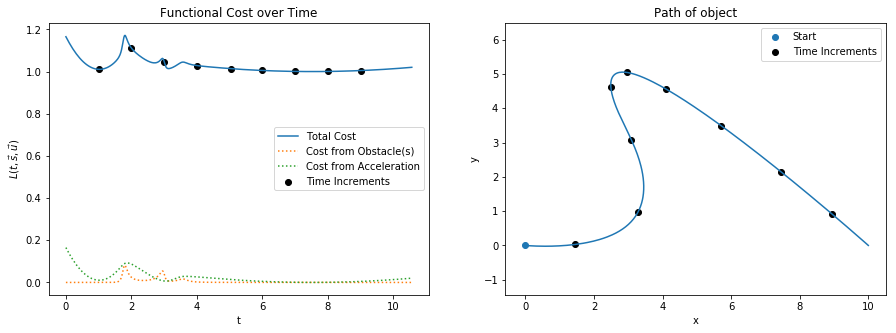

In [38]:
#Global Parameters
#K scales the penalty for intersecting objects
#M scales the pentaly for large accleration
#lamda is a constant that makes softer/harder boundaries for our obstacles
lamda = 20
K = 500
M = 0.01
params_list = [('r', 0, 3, 4, 2, 0, -0.5), ('r', 0, -3, 4, 2, 0, 0.5), ('r', 7,0,1,5,-1,0)]

def bc(ya, yb):
    "Our boundary conditions"
    return np.array([ya[0], ya[1], ya[2], ya[3], yb[0] - 10, yb[1], yb[2], yb[3]])

def x_guess(t):
    """
    A guess of the the location of x once the object has completed (t * 100)%
    of the total path
    Note that we should have x_guess(0) = 0 and x_guess(1) = final_x_location
    """
    return 10 * t

def y_guess(t):
    """
    A guess of the the location of y once the object has completed (t * 100)%
    of the total path
    Note that we should have y_guess(0) = y_guess(1) = 0
    """
    return 32 * t **4 * (t-1)**2


solution = find_path(params_list, bc, x_guess, y_guess, T_guess = 15)
animate_opt_traj(solution, params_list, bounds=[-3,10,-6,6], save_filename= "example3_3_new.mp4")

<video controls src="example3_3_new.mp4">